In [2]:
from transformers import pipeline
import torch
from glob import glob
import pandas as pd
from nltk import sent_tokenize
import nltk
import numpy as np

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load Model

In [4]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [5]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier

In [6]:
theme_classifier = load_model(device)

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
theme_list = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue"]

In [8]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
    )

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.912125289440155,
  0.47500237822532654,
  0.0878179669380188,
  0.04500036686658859,
  0.020132793113589287,
  0.012040523812174797,
  0.004292386583983898,
  0.0028172149322927]}

### Load Dataset

In [9]:
files = glob('../data/Subtitles/*.ass')

In [10]:
files[:5]

['../data/Subtitles/Naruto Season 7 - 164.ass',
 '../data/Subtitles/Naruto Season 7 - 166.ass',
 '../data/Subtitles/Naruto Season 8 - 205.ass',
 '../data/Subtitles/Naruto Season 9 - 220.ass',
 '../data/Subtitles/Naruto Season 1 - 06.ass']

In [11]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(",")[9:]) for line in lines]

In [12]:
lines[:2]

['I want to try and gather\\Nthe unrestrained winds\n',
 'I’ll run toward the horizon,\\Nalongside the wave crests\n']

In [13]:
lines = [line.replace('\\N', ' ') for line in lines]

In [14]:
lines[:2]

['I want to try and gather the unrestrained winds\n',
 'I’ll run toward the horizon, alongside the wave crests\n']

In [15]:
" ".join(lines[:10])

'I want to try and gather the unrestrained winds\n I’ll run toward the horizon, alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to go on that road.\n I’ll continue towards the future I’ve planned\n Time rushes us The heartbeat speeds up\n When I woke in the middle of a dream I kept searching for that same light\n Under the shining star-lit sky with countless constellations and shadows\n There was something beyond that… What were you gazing at?\n What were you gazing at?\n'

In [16]:
int(files[0].split("-")[-1].split(".")[0].strip())

164

In [17]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path + '/*.ass')

    scripts = []
    episode_num = []

    for path in subtitles_paths:
        # Read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]

        lines = [line.replace('\\N', ' ') for line in lines]
        script = ' '.join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode": episode_num, "script" : scripts})
    return df

In [18]:
dataset_path = '../data/Subtitles'
df = load_subtitles_dataset(dataset_path)

In [19]:
df

,episode,script
0,164,I want to try and gather the unrestrained wind...
1,166,I want to try and gather the unrestrained wind...
2,205,"Fly into the wavy and twisted sky, into your h..."
3,220,So this is the Shukaku?\n It’s the first time ...
4,6,"C'mon!\n Running like a fugitive,\n Being chas..."
...,...,...
213,23,"C'mon!\n Running like a fugitive,\n Being chas..."
214,31,"Press down hard on the gas\n That’s right, the..."
215,61,"Yeah, turn your sadness into kindness, your un..."
216,50,"Press down hard on the gas\n That’s right, the..."


### Run Model

In [20]:
script = df.iloc[0]['script']

In [21]:
script

"I want to try and gather the unrestrained winds\n I’ll run toward the horizon, alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to go on that road.\n I’ll continue towards the future I’ve planned\n Time rushes us The heartbeat speeds up\n When I woke in the middle of a dream I kept searching for that same light\n Under the shining star-lit sky with countless constellations and shadows\n There was something beyond that… What were you gazing at?\n What were you gazing at?\n Too Late for Help\n You guys did good work. Komei has confessed.\n It seems he plotted the Cursed Warrior…\n to mislead the public and to take the feudal lord position.\n Is that what Komei said?\n Yes. It turned out to be such a trifle.\n The Cursed Warrior vanishing\n was a soldier disguising himself as the Warrior\n using a strong nitrohydrochloric acid to melt his own flesh.\n It's empty again.\n With this, the Cursed Warrior incident is resolved.\n Now the Land of Birds should retu

In [22]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['I want to try and gather the unrestrained winds\n I’ll run toward the horizon, alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to go on that road.',
 'I’ll continue towards the future I’ve planned\n Time rushes us The heartbeat speeds up\n When I woke in the middle of a dream I kept searching for that same light\n Under the shining star-lit sky with countless constellations and shadows\n There was something beyond that… What were you gazing at?',
 'What were you gazing at?']

In [23]:
# Batch sentences
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = ' '.join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [24]:
script_batches[:2]

["I want to try and gather the unrestrained winds\n I’ll run toward the horizon, alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to go on that road. I’ll continue towards the future I’ve planned\n Time rushes us The heartbeat speeds up\n When I woke in the middle of a dream I kept searching for that same light\n Under the shining star-lit sky with countless constellations and shadows\n There was something beyond that… What were you gazing at? What were you gazing at? Too Late for Help\n You guys did good work. Komei has confessed. It seems he plotted the Cursed Warrior…\n to mislead the public and to take the feudal lord position. Is that what Komei said? Yes. It turned out to be such a trifle. The Cursed Warrior vanishing\n was a soldier disguising himself as the Warrior\n using a strong nitrohydrochloric acid to melt his own flesh. It's empty again. With this, the Cursed Warrior incident is resolved. Now the Land of Birds should return\n to the beautif

In [25]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [26]:
theme_output

[{'sequence': "I want to try and gather the unrestrained winds\n I’ll run toward the horizon, alongside the wave crests\n I’ve made my decision,\n even if there’s a long way to go on that road. I’ll continue towards the future I’ve planned\n Time rushes us The heartbeat speeds up\n When I woke in the middle of a dream I kept searching for that same light\n Under the shining star-lit sky with countless constellations and shadows\n There was something beyond that… What were you gazing at? What were you gazing at? Too Late for Help\n You guys did good work. Komei has confessed. It seems he plotted the Cursed Warrior…\n to mislead the public and to take the feudal lord position. Is that what Komei said? Yes. It turned out to be such a trifle. The Cursed Warrior vanishing\n was a soldier disguising himself as the Warrior\n using a strong nitrohydrochloric acid to melt his own flesh. It's empty again. With this, the Cursed Warrior incident is resolved. Now the Land of Birds should return\n t

In [27]:
# Wrangle output
themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [28]:
themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

In [29]:
themes

{'dialogue': np.float64(0.9136838018894196),
 'self development': np.float64(0.7386086285114288),
 'sacrifice': np.float64(0.6891831457614899),
 'betrayal': np.float64(0.6175152659416199),
 'battle': np.float64(0.5946104824542999),
 'friendship': np.float64(0.33070775866508484),
 'hope': np.float64(0.3281251937150955),
 'love': np.float64(0.23949497938156128)}

In [30]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = ' '.join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle output
    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

    return themes

In [31]:
df = df.head(2)

In [32]:
df

,episode,script
0,164,I want to try and gather the unrestrained wind...
1,166,I want to try and gather the unrestrained wind...


In [33]:
output_themes = df['script'].apply(get_themes_inference)

In [34]:
output_themes

0    {'dialogue': 0.9136838018894196, 'self develop...
1    {'dialogue': 0.9433566629886627, 'sacrifice': ...
Name: script, dtype: object

In [35]:
theme_df = pd.DataFrame(output_themes.tolist())

In [36]:
theme_df

,dialogue,self development,sacrifice,betrayal,battle,friendship,hope,love
0,0.913684,0.738609,0.689183,0.617515,0.594610,0.330708,0.328125,0.239495
1,0.943357,0.799818,0.851309,0.854155,0.822055,0.209874,0.387782,0.104536


In [37]:
df

,episode,script
0,164,I want to try and gather the unrestrained wind...
1,166,I want to try and gather the unrestrained wind...


In [38]:
df[theme_df.columns] = theme_df

/tmp/ipykernel_16348/949782271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[theme_df.columns] = theme_df
/tmp/ipykernel_16348/949782271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[theme_df.columns] = theme_df
/tmp/ipykernel_16348/949782271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [39]:
df

,episode,script,dialogue,self development,sacrifice,betrayal,battle,friendship,hope,love
0,164,I want to try and gather the unrestrained wind...,0.913684,0.738609,0.689183,0.617515,0.594610,0.330708,0.328125,0.239495
1,166,I want to try and gather the unrestrained wind...,0.943357,0.799818,0.851309,0.854155,0.822055,0.209874,0.387782,0.104536


### Visualize output

In [40]:
df = df.drop('dialogue', axis=1)

In [41]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,self development,1.538427
1,sacrifice,1.540492
2,betrayal,1.471670
3,battle,1.416666
4,friendship,0.540582
5,hope,0.715907
6,love,0.344031


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

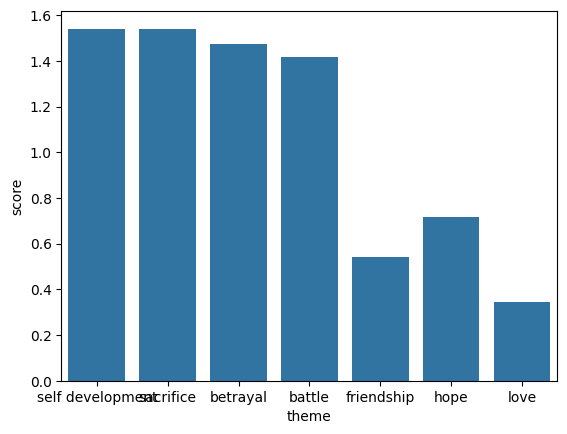

In [46]:
sns.barplot(data=theme_output, x='theme', y='score')
plt.show()